In [1]:
import torch 
import torch.nn as nn
import lightning as L

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from BalticRiverPrediction.convLSTM import ConvLSTM

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet, LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset
from BalticRiverPrediction.sharedUtilities import read_netcdfs, EnhancedMSELoss, EnhancedMSEMetric, PredictionPlottingCallback

from utility import loadData, PredictionData

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from scipy.stats import pearsonr

import glob
import os
import shutil
from datetime import datetime
import re

In [2]:
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.2)

# Matplotlib default settings
plt.rcParams.update({
    'figure.figsize': (10, 15),
    'savefig.dpi': 300,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 12,
    'font.family': 'DejaVu Serif',
})


First we search for all tested hyperparameters.

In [3]:
source_dir = "/silor/boergel/paper/runoff_prediction/data/modelWeights"

# Specify the date threshold (December 1, 2024)
# Here I started with the revisions
date_threshold = datetime(2024, 12, 1)

files = glob.glob(os.path.join(source_dir, '**', '*'), recursive=True)

modelWeightsSensitivity = []

for file in files:
    if os.path.isfile(file): 
        file_mtime = datetime.fromtimestamp(os.path.getmtime(file))
        if os.path.basename(file).startswith('last-'):
            continue
        if file_mtime >= date_threshold:
            #print(f"Added: {file}")
            modelWeightsSensitivity.append(file)

In [4]:
class PredictionData(Dataset):
    def __init__(self, input_size, atmosphericData, runoff, atmosStats, runoffStats, transform=None):

        self.input_size = input_size
        runoffData = runoff.transpose("time", "river")
        
        X = ((atmosphericData - atmosStats[0])/atmosStats[1]).compute()
        y = ((runoffData - runoffStats[0])/runoffStats[1]).compute()
        
        xStacked = X.to_array(dim='variable')
        xStacked = xStacked.transpose("time", "variable", "y", "x")

        assert xStacked.data.ndim == 4
        self.x = torch.tensor(xStacked.data, dtype=torch.float32)
        self.y = torch.tensor(y.data, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x[index:index+(self.input_size)], self.y[index+int(self.input_size)]

    def __len__(self):
        return self.y.shape[0]-(self.input_size)

In [5]:
data, runoff = loadData()

In [6]:
Neva = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/Neva.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
Neva.index = pd.to_datetime(Neva.index)


In [7]:
Oder = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/Odra.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
Oder.index = pd.to_datetime(Oder.index)

In [8]:
Neman = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/Neman.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
Neman.index = pd.to_datetime(Neman.index)

In [9]:
UmeAlv = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/UmeAlv.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
UmeAlv.index = pd.to_datetime(UmeAlv.index)

Now we need to loop over the weights

In [10]:
runoff_weights = {
}

In [11]:
# pattern = r'ModelWeight_H(\d+)_K\((\d+x\d+)\)_I(\d+)_L(\d+)'
# match = re.search(pattern, weights)

# if match:
#     # Extract values from the regex match groups
#     H = match.group(1)  # H6
#     K = match.group(2)  # (7x7)
#     I = match.group(3)  # 30
#     L = match.group(4)  # 
#     K_tuple = tuple(map(int, K.strip('()').split('x')))



In [12]:
# time_len = len(data.time)
# river_len = len(runoff.river)
# runoffPlaceHolder = xr.Dataset(
#     {
#         "roflux": (["river", "time"], np.zeros((river_len, time_len)))
#     },
#     coords={
#         "time": data.time,
#         "river": runoff.river
#     }
# )

In [18]:
# Pre-load the data once to avoid repeated slicing
data_slice = data.sel(time=slice("1979", "2011"))
runoff_slice = runoff.sel(time=slice("1979", "2011"))

# Define the trainer once for all models
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
)

# Initialize a list to store the models and predictions
predictions_all = []

# Loop through each set of weights
for weights in modelWeightsSensitivity:
    ######
    ## Setup model
    #####
    pattern = r'ModelWeight_H(\d+)_K\((\d+x\d+)\)_I(\d+)_L(\d+)'
    match = re.search(pattern, weights)

    H = match.group(1)
    K = match.group(2)
    I = match.group(3)
    LAYER = match.group(4)
    K_tuple = tuple(map(int, K.strip('()').split('x')))

    modelParameters = {
        "input_dim": 4,
        "hidden_dim": int(H),
        "kernel_size": K_tuple,
        "num_layers": int(LAYER),
        "batch_first": True,
        "bias": True,
        "return_all_layers": False,
        "dimensions": (222, 244),
        "input_size": int(I)
    }

    pyTorchBaltNet = BaltNet(modelPar=modelParameters)

    LightningBaltNet = LightningModel.load_from_checkpoint(
        checkpoint_path=weights,
        map_location="cuda",
        model=pyTorchBaltNet,
        cosine_t_max=100
    )

    print("Model loaded")

    ######
    ## Setup dataLoader
    #####
    # dataDataset = AtmosphericDataset(
    #     atmosphericData=data_slice,
    #     runoff=runoff_slice,
    #     input_size=modelParameters["input_size"],
    # )

    dataLoader = AtmosphereDataModule(
        atmosphericData=data_slice,
        runoff=runoff_slice,
        batch_size=100,
        input_size=modelParameters["input_size"],
        num_workers=16
    )

    dataLoader.setup(stage="")

    print("Starting prediction")
    predictions = trainer.predict(LightningBaltNet, dataloaders=dataLoader.test_dataloader())

    # Process predictions in batches directly into the result array
    testDataList = []
    for _, batch in dataLoader.test:
        testDataList.append(batch)
    
    testData = np.vstack(testDataList)

    # Concatenate predictions directly for each model
    concatenated_predictions = torch.cat(predictions, dim=0)

    # Rescale predictions
    rescaledRunoffData = concatenated_predictions * dataLoader.runoffDataStats[1].data + dataLoader.runoffDataStats[0].data
    rescaledTestData = testData * dataLoader.runoffDataStats[1].data + dataLoader.runoffDataStats[0].data

    runoffData = xr.Dataset(
        {
            "prediction": (("time", "river"), rescaledRunoffData),
            "original": (("time", "river"), rescaledTestData)
        },
        coords={
            "time": np.arange(len(rescaledRunoffData)),
            "river": np.arange(97)
        }
    )

    runoff_weights[os.path.basename(weights)] = runoffData

    # Clean up memory by freeing unused GPU memory
    torch.cuda.empty_cache()



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

Model loaded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting prediction


Predicting: 0it [00:00, ?it/s]

In [14]:
# for weights in modelWeightsSensitivity:


#     ######
#     ## Setup model
#     ##
#     #####
#     pattern = r'ModelWeight_H(\d+)_K\((\d+x\d+)\)_I(\d+)_L(\d+)'
#     match = re.search(pattern, weights)

#     H = match.group(1)  
#     K = match.group(2)  
#     I = match.group(3)  
#     LAYER = match.group(4)  
#     K_tuple = tuple(map(int, K.strip('()').split('x')))

#     modelParameters = {
#     "input_dim": 4,
#     "hidden_dim": int(H),
#     "kernel_size": K_tuple,
#     "num_layers": int(LAYER),
#     "batch_first": True,
#     "bias": True,
#     "return_all_layers": False,
#     "dimensions": (222,244),
#     "input_size": int(I)
#     }

#     pyTorchBaltNet = BaltNet(modelPar=modelParameters)

#     LightningBaltNet = LightningModel.load_from_checkpoint(
#     checkpoint_path=weights,
#     map_location="cuda",
#     model=pyTorchBaltNet,
#     cosine_t_max=100
#     )

#     print("Model loaded")

#     ######
#     ## Setup dataLoader 
#     ##
#     #####


#     # dataDataset = AtmosphericDataset(
#     #     atmosphericData=data.sel(time=slice("1979", "2011")),
#     #     runoff=runoff.sel(time=slice("1979", "2011")),
#     #     input_size=modelParameters["input_size"],
#     # )

#     dataLoader = AtmosphereDataModule(
#         atmosphericData=data.sel(time=slice("1979", "2011")),
#         runoff=runoff.sel(time=slice("1979", "2011")),
#         batch_size=100,
#         input_size=modelParameters["input_size"],
#         num_workers=16
#     )

#     dataLoader.setup(stage="")

#     trainer = L.Trainer(
#     inference_mode=True,
#     accelerator="cuda",
#     devices=1,
#     )  
#     print("Starting prediction")
#     predictions = trainer.predict(LightningBaltNet, dataloaders=dataLoader.test_dataloader())
#     # We need to extract the 
#     # testData = np.zeros((len(dataLoader.test), 97))
#     # iterater = iter(dataLoader.test)
#     # for i in range(len(dataLoader.test)):
#     #     batch = next(iterater)[1]
#     #     testData[i,:] = batch
    
#     testDataList = []
#     for _, batch in dataLoader.test:
#         testDataList.append(batch)  
#     testData = np.vstack(testDataList)
    
#     # PredictionDataset = PredictionData(
#     #     atmosphericData=data,
#     #     runoff=runoffPlaceHolder.roflux,
#     #     input_size=modelParameters["input_size"],
#     #     atmosStats=dataDataset.atmosphericStats,
#     #     runoffStats=dataDataset.runoffDataStats,
#     # )
#     # predict_dataloader = DataLoader(
#     # PredictionDataset,
#     # batch_size=50,
#     # shuffle=False,
#     # drop_last=True
#     # )

#     ########
#     ####
#     ###
#     ###
#     trainer = L.Trainer(
#     inference_mode=True,
#     accelerator="cuda",
#     devices=1,
#     )   
#     #predictions = trainer.predict(LightningBaltNet, dataloaders=predict_dataloader)
#     #concatenated_predictions = torch.cat(predictions, dim=0) # concat in time
#     concatenated_predictions = torch.cat(predictions, dim=0) # concat in time
#     rescaledRunoffData = concatenated_predictions*dataLoader.runoffDataStats[1].data+dataLoader.runoffDataStats[0].data
#     rescaledTestData = testData*dataLoader.runoffDataStats[1].data+dataLoader.runoffDataStats[0].data   
#     runoffData = xr.Dataset(
#         {
#             "prediction":(("time", "river"), rescaledRunoffData),
#             "original":(("time","river"), rescaledTestData)
#         },
#         coords={
#             "time": np.arange(len(rescaledRunoffData)),
#             "river":np.arange(97)
#         }
#     )
#     runoff_weights[os.path.basename(weights)] = runoffData

Model loaded


KeyboardInterrupt: 

Text(0.5, 0, 'Time [days]')

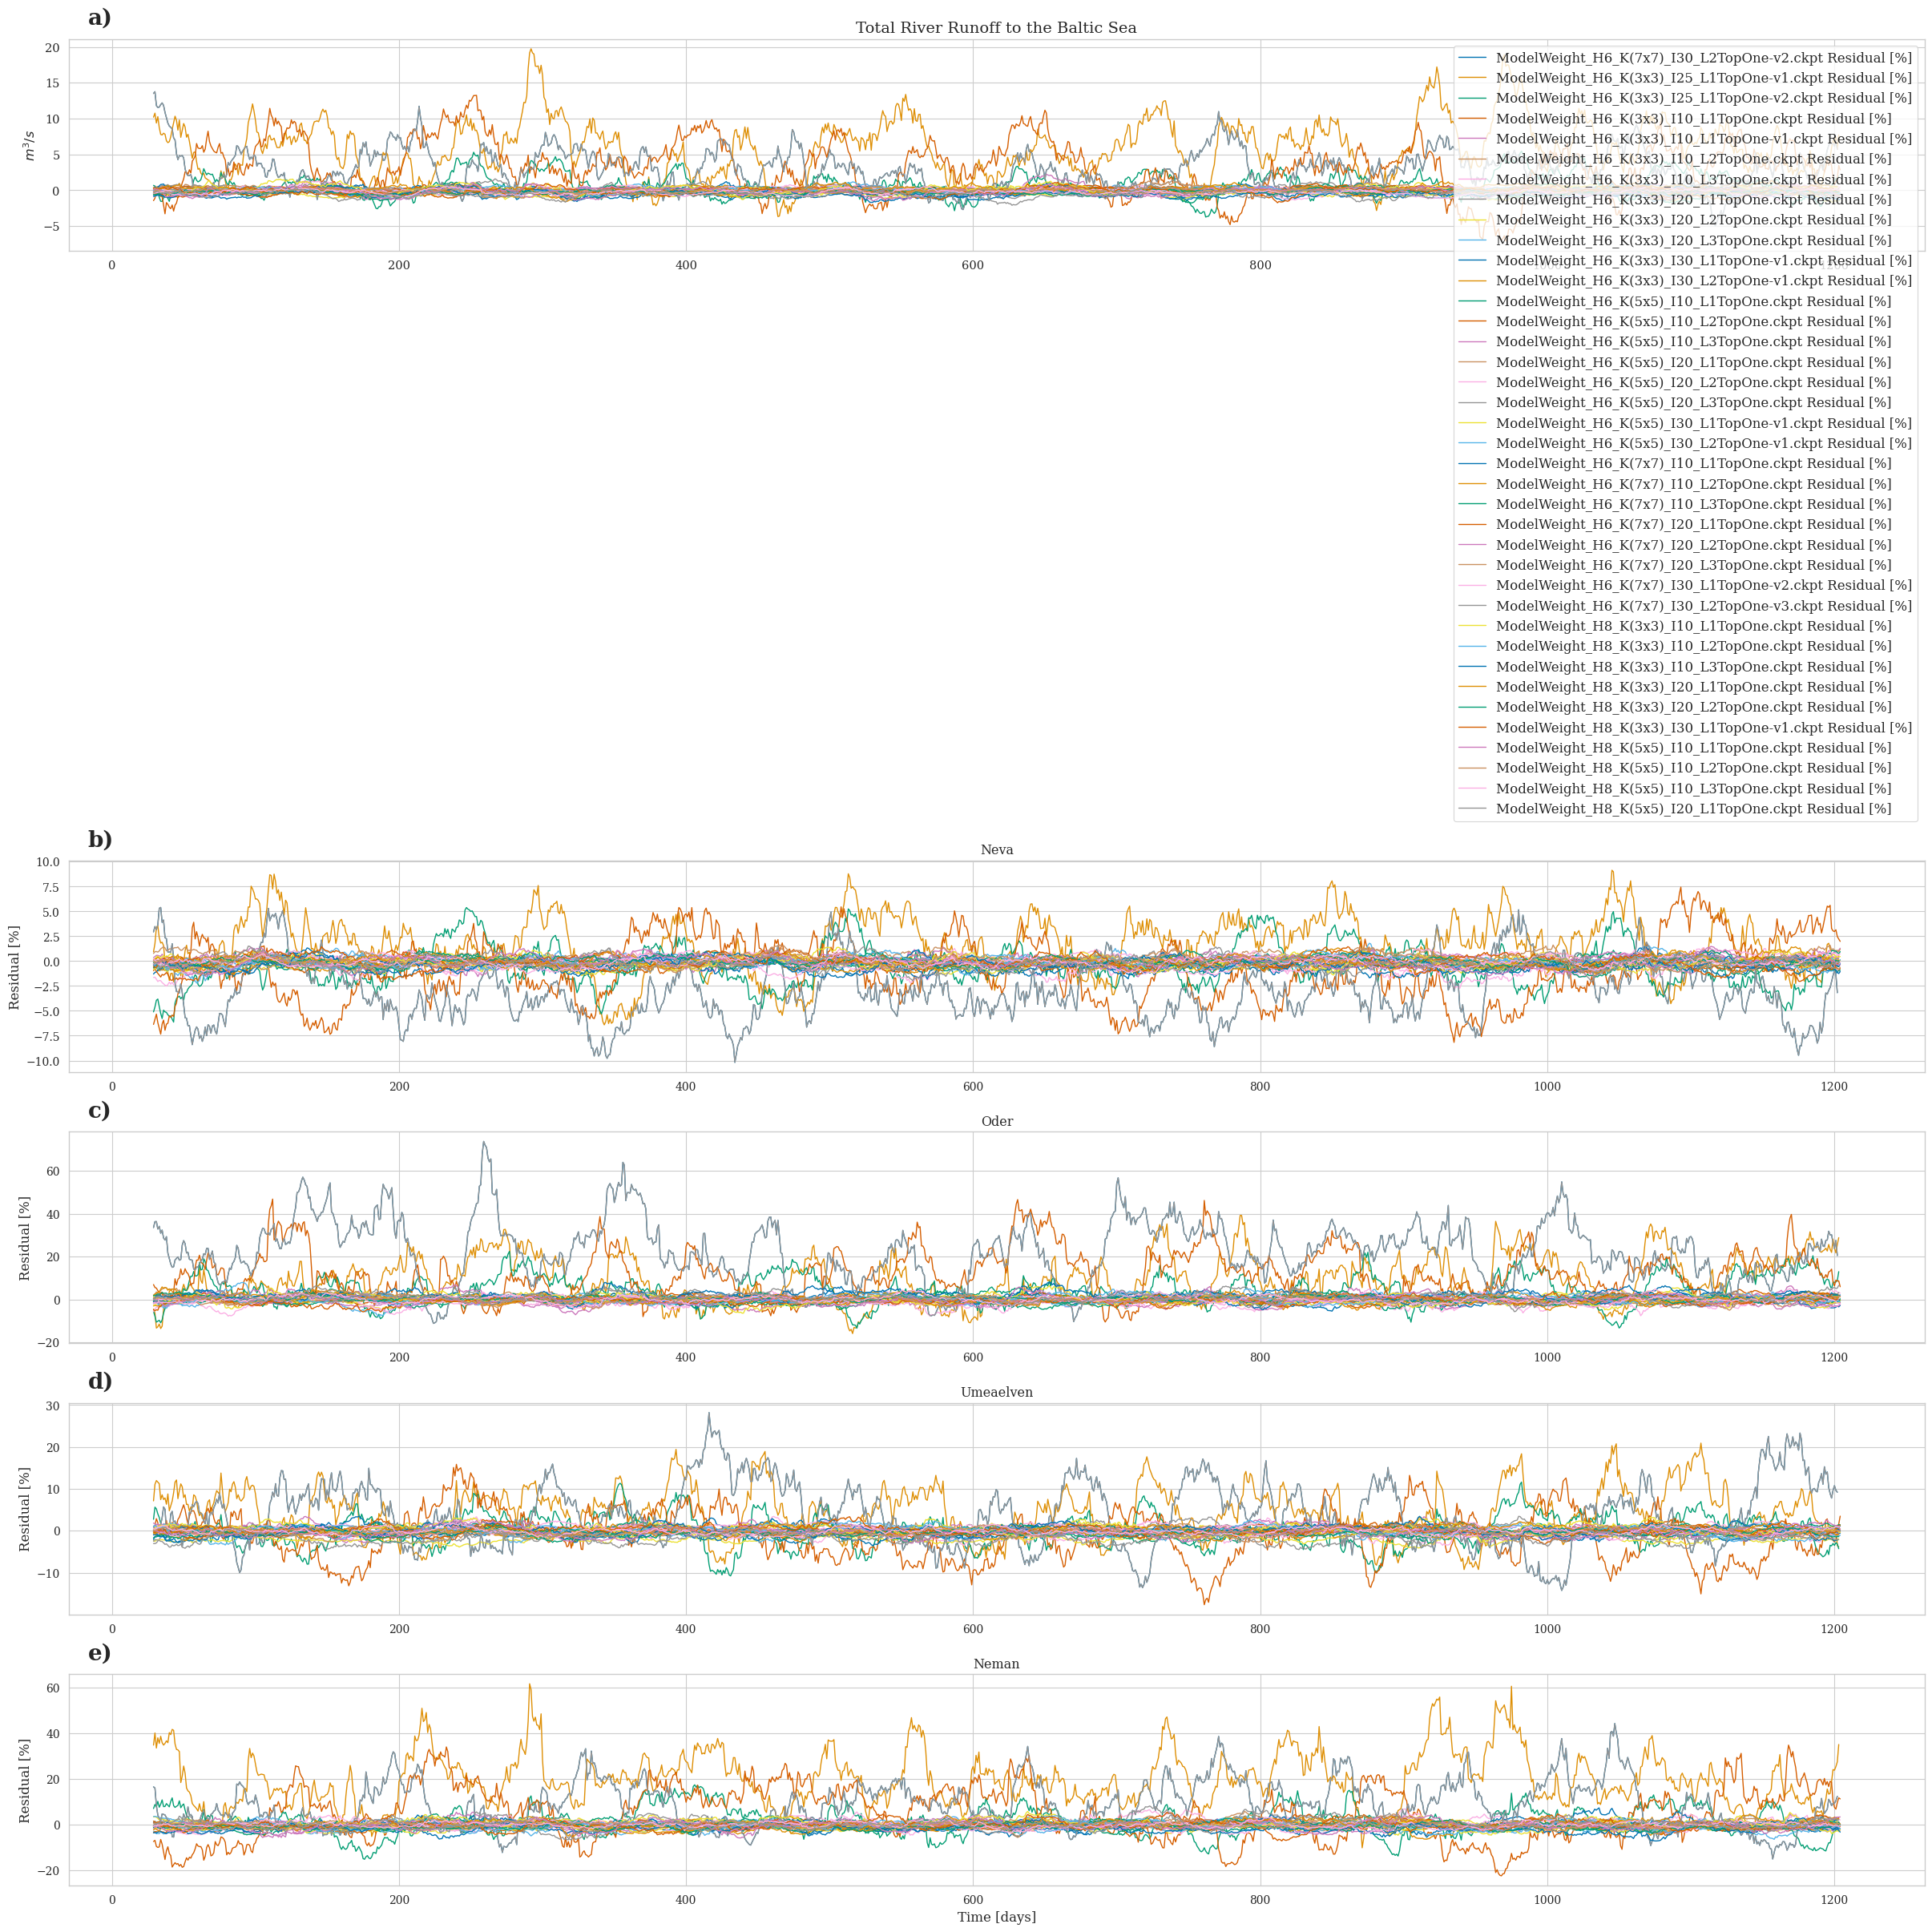

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.2)

rolling_window_size = 30
fig = plt.figure(figsize=(24, 24), constrained_layout=True)
gs = fig.add_gridspec(nrows=5, ncols=1, left=0.05, right=0.95)

ax0 = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[i + 1, 0], sharex=ax0) for i in range(4)]

# Loop through the dictionary to plot each model's data
for model_name, model_data in runoff_weights.items():
    # Model-specific rolling averages
        runoffData5d = model_data.sum("river").rolling(time=rolling_window_size).mean()
        residual = (runoffData5d['prediction'] - runoffData5d['original']) / runoffData5d['original']
        (residual * 100).plot(ax=ax0, label=f'{model_name} Residual [%]', linewidth=1)

# General formatting for ax0
ax0.set_title('Total River Runoff to the Baltic Sea', fontsize=14)
ax0.set_ylabel("$m^3/s$")
ax0.set_xlabel("")
ax0.legend(fontsize=12, loc='upper right')
ax0.text(0.01, 1.15, 'a)', transform=ax0.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

annotations = ['b)', 'c)', 'd)', 'e)']  
largest_rivers = runoffData.sum(dim='time').to_array().sum(dim='variable').argsort()[::-1][0:4]
riversWithData = [56, 2, 78, 15]

# Plot residuals for each river in the list
for i, river in enumerate(riversWithData):
    for model_name, model_data in runoff_weights.items():
        runoffData5d = model_data.rolling(time=rolling_window_size).mean()
        residual = (runoffData5d.isel(river=river)['prediction'] - runoffData5d.sel(river=river)['original']) / runoffData5d.sel(river=river)['original']
        (residual * 100).plot(ax=axes[i], label=f'{model_name} Residual [%]', linewidth=1)

    # Add annotations
    axes[i].text(0.01, 1.15, annotations[i], transform=axes[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# Assign titles for each river
axes[3].set_title("Neman")
axes[2].set_title("Umeaelven")
axes[1].set_title("Oder")
axes[0].set_title("Neva")

# Format axes
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylabel("Residual [%]", fontsize=12)
    ax.set_xlabel("", fontsize=12)

ax.set_xlabel("Time [days]", fontsize=12)

# Save the plot
# fig.savefig("figures/paper_total_river_runoff.png", dpi=300)


In [24]:
def calculate_rmse(original, prediction):
    return np.sqrt(np.mean((original - prediction) ** 2))

def calculate_mae(original, prediction):
    return np.mean(np.abs(original - prediction))

def calculate_correlation(original, prediction):
    corr, _ = pearsonr(original, prediction)
    return corr

rolling_window_size = 1

metrics = []

for model_name, model_data in runoff_weights.items():

    summed_pred = model_data['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')
    summed_orig = model_data['original'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')

    # Calculate metrics for the current model
    rmse_val = calculate_rmse(summed_orig, summed_pred)
    mae_val = calculate_mae(summed_orig, summed_pred)
    correlation_val = calculate_correlation(summed_orig, summed_pred)

    # Store the results
    metrics.append({
        'model_name': model_name,
        'RMSE': rmse_val,
        'MAE': mae_val,
        'Correlation': correlation_val
    })

# Convert metrics to a DataFrame for better readability and visualization
metrics_df = pd.DataFrame(metrics)
metrics_df_sorted = metrics_df.sort_values(by='RMSE', ascending=True)

# Print metrics DataFrame
print(metrics_df_sorted)

                                    model_name  \
25     ModelWeight_H6_K(7x7)_I20_L3TopOne.ckpt   
24     ModelWeight_H6_K(7x7)_I20_L2TopOne.ckpt   
17     ModelWeight_H6_K(5x5)_I20_L3TopOne.ckpt   
19  ModelWeight_H6_K(5x5)_I30_L2TopOne-v1.ckpt   
16     ModelWeight_H6_K(5x5)_I20_L2TopOne.ckpt   
11  ModelWeight_H6_K(3x3)_I30_L2TopOne-v1.ckpt   
32     ModelWeight_H8_K(3x3)_I20_L2TopOne.ckpt   
8      ModelWeight_H6_K(3x3)_I20_L2TopOne.ckpt   
36     ModelWeight_H8_K(5x5)_I10_L3TopOne.ckpt   
21     ModelWeight_H6_K(7x7)_I10_L2TopOne.ckpt   
9      ModelWeight_H6_K(3x3)_I20_L3TopOne.ckpt   
13     ModelWeight_H6_K(5x5)_I10_L2TopOne.ckpt   
5      ModelWeight_H6_K(3x3)_I10_L2TopOne.ckpt   
22     ModelWeight_H6_K(7x7)_I10_L3TopOne.ckpt   
35     ModelWeight_H8_K(5x5)_I10_L2TopOne.ckpt   
29     ModelWeight_H8_K(3x3)_I10_L2TopOne.ckpt   
23     ModelWeight_H6_K(7x7)_I20_L1TopOne.ckpt   
26  ModelWeight_H6_K(7x7)_I30_L1TopOne-v2.ckpt   
15     ModelWeight_H6_K(5x5)_I20_L1TopOne.ckpt   


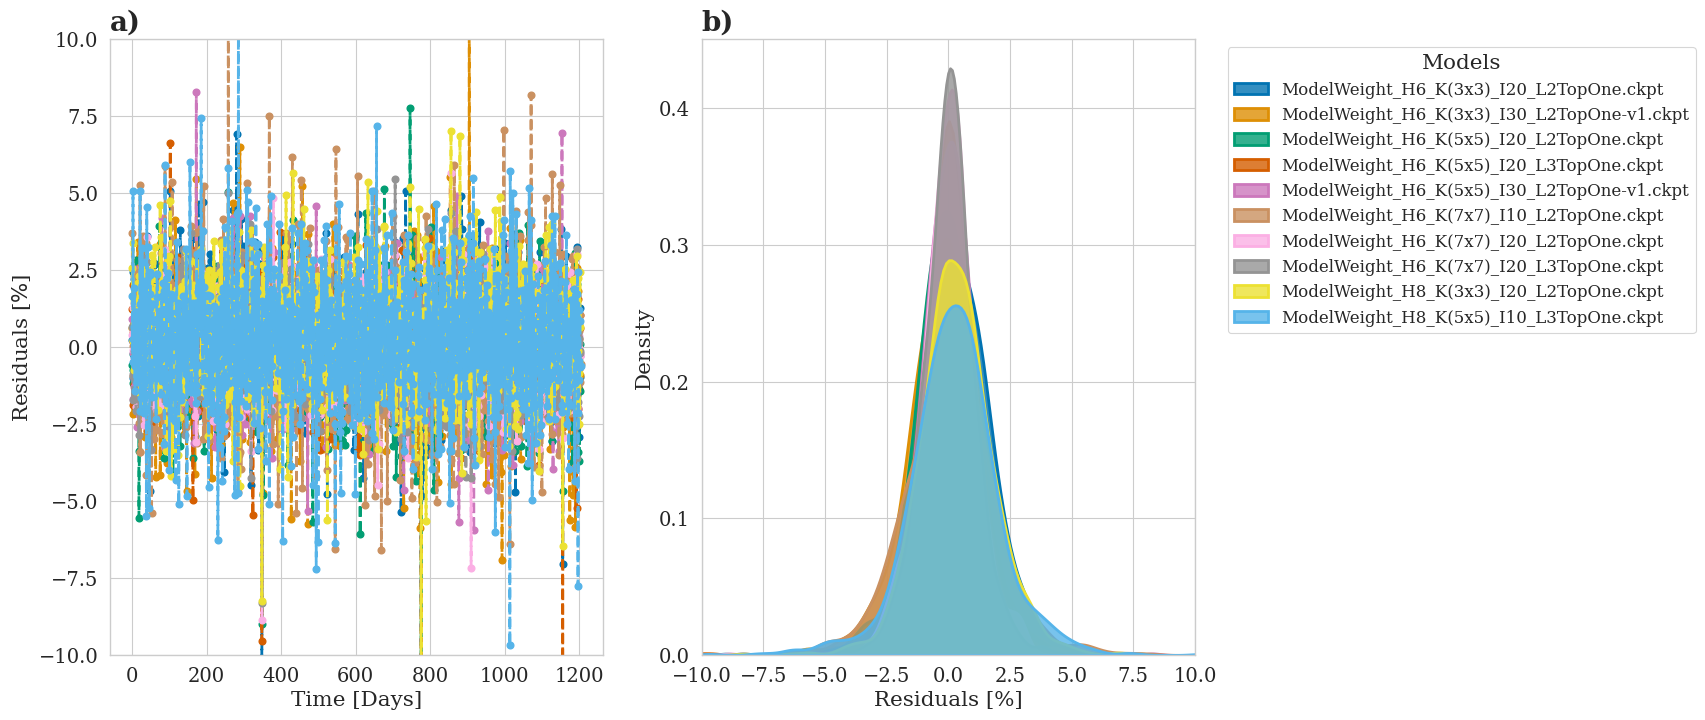

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the metrics by correlation value in descending order and extract the top 3 models
top_models = metrics_df.sort_values(by='Correlation', ascending=False).head(10)

# Plotting the residuals and density plots for the top 3 models
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.6)

# Create a figure with 2 subplots
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(14, 8))

# Loop through the top 3 models to plot their residuals and density plot
for i, (model_name, model_data) in enumerate(runoff_weights.items()):
    if model_name not in top_models['model_name'].values:
        continue  # Only plot the top 3 models
    
    summed_pred = model_data['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')
    summed_orig = model_data['original'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')

    # Residuals
    residuals = summed_orig - summed_pred
    residualsPct = residuals / summed_orig * 100
    ax2.plot(summed_orig.time.values, residualsPct, label=model_name, marker='o', linestyle='--', linewidth=2)

    # Density plot for residuals
    sns.kdeplot(residuals / summed_orig * 100, alpha=0.8, ax=ax3, fill=True, label=model_name, linewidth=2)


# Residuals plot formatting
ax2.set_xlabel('Time [Days]')
ax2.set_ylabel('Residuals [$\%$]')
ax2.set_ylim([-10, 10])  # Zoom in on the residuals range
ax2.set_title('a)', loc="left", fontsize=20, fontweight="bold")
#ax2.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Density plot formatting
ax3.set_xlabel('Residuals [%]')
ax3.set_title('b)', loc="left", fontsize=20, fontweight="bold")
ax3.set_xlim([-10, 10])  # Adjust the x-axis range to match residuals
ax3.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust layout for better spacing and visibility
#fig.tight_layout()

# Save the plot
fig.savefig("figures/paper_error_metrics_top_3_models.png", dpi=300, bbox_inches='tight')
